# <a href="https://www.kaggle.com/puneet6060/intel-image-classification">Intel image classification</a>
- Kaggle Intel Image classification dataset을 이용한 분류기이다.
- 본 실습을 통해 기존에 진행했던 <a href="https://github.com/elixter/Is_That_a_Supra">Is that a supra?</a>프로젝트(?)의 정확도를 높히기 위해 시작하였다.
- **코드 참조**
https://www.kaggle.com/nageshsingh/nature-image-classification

**Context**  
This is image data of Natural Scenes around the world.

**Content**  
This Data contains around 25k images of size 150x150 distributed under 6 categories.  
{'buildings' -> 0,  
'forest' -> 1,  
'glacier' -> 2,  
'mountain' -> 3,  
'sea' -> 4,  
'street' -> 5 }  

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

**Acknowledgements**  
Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data

Photo by Jan Böttinger on Unsplash

**Inspiration**  
Want to build powerful Neural network that can classify these images with more accuracy.

In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from random import randint

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import applications

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# GPU 메모리 조절 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def get_image(directory):
    Images = []
    Labels = []
    label = 0
    
    for labels in os.listdir(directory):
        if labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'glacier':
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'street':
            label = 5
            
        for image_file in os.listdir(directory + labels):
            image = cv2.imread(directory + labels + r'/' + image_file)
            image = cv2.resize(image, (150, 150))
            Images.append(image)
            Labels.append(label)
            
        return shuffle(Images, Labels, random_state=12329173)
    

def get_classlabel(class_code):
    labels = {0 : 'buildings',
              1 : 'forest',
              2 : 'glacier',
              3 : 'mountain',
              4 : 'sea',
              5 : 'street',
             }
    
    return labels[class_code]

In [4]:
# Load train image
Images, Labels = get_image('./seg_train/seg_train/')

Images = np.array(Images, dtype=np.float32)
Images = Images / 255.0
Labels = np.array(Labels)

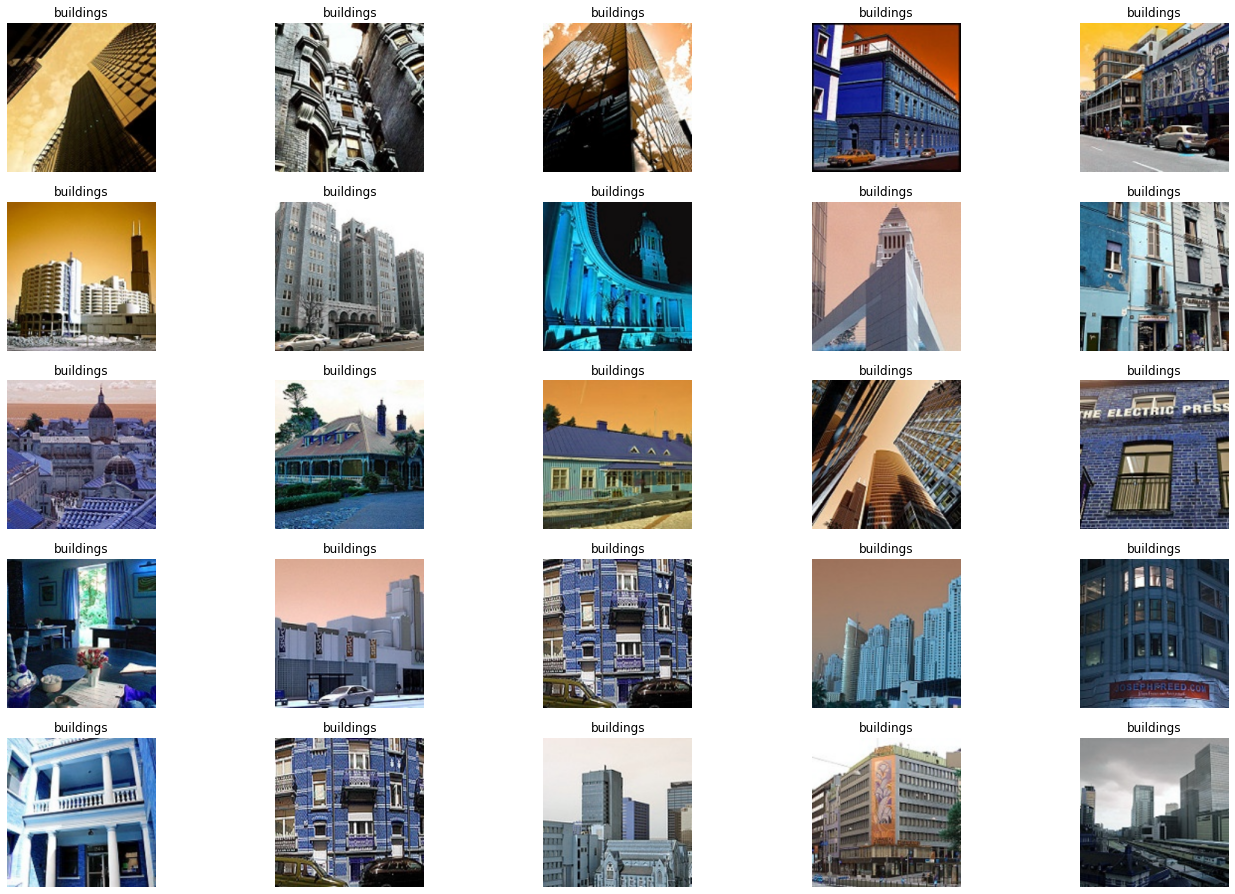

In [5]:
# Image plot
f, ax = plt.subplots(5, 5)
f.subplots_adjust(0,0,3,3)
for i in range(0, 5, 1):
    for j in range(0, 5, 1):
        rand_num = randint(0, len(Images))
        ax[i, j].imshow(Images[rand_num])
        ax[i, j].set_title(get_classlabel(Labels[rand_num]))
        ax[i, j].axis('off')

In [6]:
# Image generate

train_DIR = "./seg_train/seg_train"

train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  vertical_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_DIR,
                                                   batch_size=8,
                                                   class_mode='categorical',
                                                   target_size=(150, 150))

test_DIR = "./seg_test/seg_test"

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(test_DIR,
                                                             batch_size=8,
                                                             class_mode='categorical',
                                                             target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Transfer Learning
- 본 노트북에서 미리 학습된 ResNet50를 이용하여 모델을 구성하였다. (원래 코드는 Inception 구조 사용)
- 출력층을 6개의 클래스로 바꿔주어야하기 때문에 include_top을 False로 설정해 주었다.

In [7]:
base_model = applications.ResNet50 (
    input_shape=(150, 150, 3),
    include_top = False,
    classes=len(Images),
)

In [8]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
base_output = base_model.output
x = tf.keras.layers.Flatten()(base_output)
x = tf.keras.layers.Dense(units=2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=1,
                                           verbose=1,
                                           factor=0.25,
                                           min_lr=0.000003)

model = tf.keras.Model(base_model.input, x)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [12]:
history = model.fit(train_generator,
                   epochs = 10,
                   verbose = 1,
                   validation_data = validation_generator,
                   callbacks=[learning_rate_reduction],
                   )

Epoch 1/10
1755/1755 [==============================] - 179s 98ms/step - loss: 3.5335 - accuracy: 0.3760 - val_loss: 1.1942 - val_accuracy: 0.5253
Epoch 2/10
1755/1755 [==============================] - 170s 97ms/step - loss: 0.9383 - accuracy: 0.6225 - val_loss: 0.7174 - val_accuracy: 0.7083
Epoch 3/10
1755/1755 [==============================] - 170s 97ms/step - loss: 0.8897 - accuracy: 0.6430 - val_loss: 1.4048 - val_accuracy: 0.4990

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/10
1755/1755 [==============================] - 170s 97ms/step - loss: 0.7010 - accuracy: 0.7363 - val_loss: 0.8183 - val_accuracy: 0.6840

Epoch 00004: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 5/10
1755/1755 [==============================] - 172s 98ms/step - loss: 0.5610 - accuracy: 0.7868 - val_loss: 0.4350 - val_accuracy: 0.8447
Epoch 6/10
1755/1755 [==============================] - 173s 98ms/step - loss: 0.5080 - accuracy: 0.8098

### **정확도, 손실 그래프**
- ResNet50을 사용하기전 InceptionResnetv2도 사용해 본 결과 ResNet50이 훨씬 더 학습속도가 빠르고 성능이 잘 나왔다.
- Epoch를 늘린다면 더 좋은 성능이 나올것으로 예상.

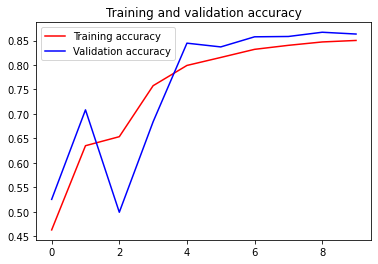

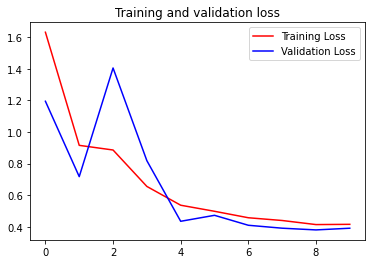

In [13]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 결과물
- 예측결과는 애석하게도 정확하지않다. loss가 무려 40&대와 정확도가 80%대 밖에 되지않으니 당연한 결과라 생각한다.
- 위에서도 언급했듯이 학습이 되는과정을 보아선 Epoch를 더 늘려준다면 좋은 성능이 나올것으로 기대된다.

Prediction for this image is : mountain


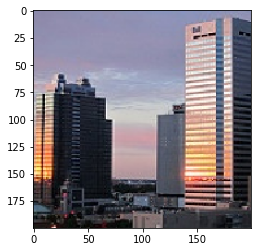

In [21]:
import numpy as np
from keras.preprocessing import image

file_path =  './seg_pred/seg_pred/5.jpg'

test_image = image.load_img(file_path, target_size = (150, 150))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

classes=train_generator.class_indices

classes=['buildings','forest','glacier','mountain','sea','street']

print("Prediction for this image is :",classes[np.argmax(result)])